<a href="https://colab.research.google.com/github/Daniel2291/SFCNN/blob/main/SFCNN_ISBI_Recreation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Required Packages Installation

In [ ]:
!pip install torch torchvision numpy scikit-image Pillow matplotlib scikit-learn

Unzipping ISBI Dataset

In [ ]:
!unzip -q ISBI-2012-challenge.zip -d isbi_dataset

Training The Model

In [ ]:
#
# ISBI Challenge Training Script with Agglomerative Clustering
#
# =================================================================================
# This script is for TRAINING the SteerableUNet model. It uses a training dataset
# and a separate validation (test) dataset.
#
# NOTE ON DEPENDENCIES:
# This version uses a more advanced graph-based segmentation algorithm implemented
# with 'scikit-image' to avoid difficult installations of libraries like 'nifty'.
#
# Required libraries (install with pip):
# > pip install torch torchvision numpy scikit-image Pillow matplotlib scikit-learn
# =================================================================================
#
# The pipeline consists of three main stages:
# 1. Boundary Prediction: The Steerable Filter CNN (SFCNN) predicts cell boundaries.
# 2. Superpixel Generation: A watershed algorithm creates an oversegmentation.
# 3. Graph-based Segmentation: An agglomerative clustering on the Region Adjacency
#    Graph (RAG) merges regions iteratively to produce the final segmentation.
#

import os
# FIX for torch._dynamo circular import error in some environments.
# This environment variable MUST be set BEFORE importing torch.
os.environ['TORCH_COMPILE_DISABLE'] = '1'

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.checkpoint import checkpoint # Import for gradient checkpointing
from torchvision.transforms import Compose, RandomAffine, ToTensor, Normalize
from PIL import Image

import numpy as np
from scipy.ndimage import distance_transform_edt
from skimage.segmentation import watershed
from skimage.measure import label
from skimage import graph as sk_graph

import math
import matplotlib.pyplot as plt

#
# Model Definition
#

def generate_circular_harmonics_basis(kernel_size, radial_params, max_angular_freqs):
    """
    Generates a basis of complex-valued circular harmonic filters.
    """
    filters = []
    angular_freqs_k = []

    x = torch.linspace(-kernel_size // 2, kernel_size // 2, kernel_size)
    grid_x, grid_y = torch.meshgrid(x, x, indexing='ij')
    r = torch.sqrt(grid_x**2 + grid_y**2)
    phi = torch.atan2(grid_y, grid_x)

    for i, (mean, std) in enumerate(radial_params):
        radial_profile = torch.exp(-(r - mean)**2 / (2 * std**2))
        for k in range(max_angular_freqs[i] + 1):
            angular_part = torch.exp(1j * k * phi)
            filt = radial_profile * angular_part
            norm = torch.sqrt(torch.sum(torch.real(filt)**2 + torch.imag(filt)**2))
            if norm > 1e-6:
                filt = filt / norm
            filters.append(filt)
            angular_freqs_k.append(k)

    return torch.stack(filters).cfloat(), torch.tensor(angular_freqs_k, dtype=torch.float32)

class SteerableCNNLayer(nn.Module):
    """
    A steerable convolution layer that can act as the input layer or a group convolution layer.
    """
    def __init__(self, in_channels, out_channels, kernel_size, num_orientations,
                 radial_params, max_angular_freqs, is_input_layer=False):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_orientations = num_orientations
        self.is_input_layer = is_input_layer

        basis, k_values = generate_circular_harmonics_basis(kernel_size, radial_params, max_angular_freqs)
        self.num_basis_filters = basis.shape[0]
        self.register_buffer('basis', basis)
        self.register_buffer('k_values', k_values)

        weight_shape = (out_channels, in_channels, self.num_orientations, self.num_basis_filters) if not is_input_layer else (out_channels, in_channels, self.num_basis_filters)
        stdv = 1. / math.sqrt(in_channels * self.num_basis_filters)
        self.weights = nn.Parameter(torch.randn(*weight_shape, dtype=torch.cfloat) * stdv)

        orientations = torch.linspace(0, 2 * np.pi, self.num_orientations + 1)[:-1]
        phase_factors = torch.exp(-1j * self.k_values[None, :] * orientations[:, None])
        self.register_buffer('phase_factors', phase_factors.cfloat())

    def forward(self, x):
        if not torch.is_complex(x):
             x = x.cfloat()

        if self.is_input_layer:
            x = x.unsqueeze(2)

        N, C_in, A_in, H, W = x.shape
        x_reshaped = x.reshape(N * C_in * A_in, 1, H, W)

        atomic_responses = F.conv2d(x_reshaped, self.basis.unsqueeze(1), padding='same')
        atomic_responses = atomic_responses.view(N, C_in, A_in, self.num_basis_filters, H, W)

        output = []
        for theta_idx in range(self.num_orientations):
            if self.is_input_layer:
                atomic_squeezed = atomic_responses.squeeze(2)
                phase_for_theta = self.phase_factors[theta_idx, :]
                coeffs = self.weights * phase_for_theta[None, None, :]
                y_theta = torch.einsum('oib,nibxy->noxy', coeffs, atomic_squeezed)
            else:
                w_rolled = torch.roll(self.weights, shifts=-theta_idx, dims=2)
                phase_for_phi = self.phase_factors[:A_in, :]
                coeffs = w_rolled * phase_for_phi[None, None, :, :]
                y_theta = torch.einsum('oipb,nipbxy->noxy', coeffs, atomic_responses)

            output.append(y_theta)

        y = torch.stack(output, dim=2)
        return torch.real(y)

class SteerableUNet(nn.Module):
    """A U-Net using SteerableCNNLayers, adjusted for BCEWithLogitsLoss."""
    def __init__(self, n_channels_in, n_classes, num_orientations=8, kernel_size=5):
        super().__init__()
        self.num_orientations = num_orientations
        radial_params = [(0.0, 1.0), (kernel_size / 4, 1.0)]
        max_angular_freqs = [4, 4]

        c1, c2, c3 = 8, 16, 32

        self.in_layer = SteerableCNNLayer(n_channels_in, c1, kernel_size, self.num_orientations, radial_params, max_angular_freqs, is_input_layer=True)
        self.enc1 = SteerableCNNLayer(c1, c2, kernel_size, self.num_orientations, radial_params, max_angular_freqs)
        self.pool = nn.MaxPool3d(kernel_size=(1, 2, 2))
        self.bottle = SteerableCNNLayer(c2, c3, kernel_size, self.num_orientations, radial_params, max_angular_freqs)
        self.up = nn.Upsample(scale_factor=(1, 2, 2), mode='trilinear', align_corners=False)
        self.dec1 = SteerableCNNLayer(c3 + c2, c2, kernel_size, self.num_orientations, radial_params, max_angular_freqs)
        self.dec2 = SteerableCNNLayer(c2 + c1, c1, kernel_size, self.num_orientations, radial_params, max_angular_freqs)
        self.out_conv = nn.Conv2d(c1, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = F.relu(checkpoint(self.in_layer, x, use_reentrant=False))
        x2 = F.relu(checkpoint(self.enc1, self.pool(x1), use_reentrant=False))
        b = F.relu(checkpoint(self.bottle, self.pool(x2), use_reentrant=False))

        cat1 = torch.cat([self.up(b), x2], dim=1)
        d1 = F.relu(checkpoint(self.dec1, cat1, use_reentrant=False))

        cat2 = torch.cat([self.up(d1), x1], dim=1)
        d2 = F.relu(checkpoint(self.dec2, cat2, use_reentrant=False))

        out_pooled = torch.max(d2, dim=2)[0]
        return self.out_conv(out_pooled)

#
# Data Loading and Inference Functions
#

class TiffStackDataset(Dataset):
    """
    Custom PyTorch Dataset for loading multi-page TIFF stacks.
    """
    def __init__(self, data_file, labels_file, transform=None):
        self.data_file = data_file
        self.labels_file = labels_file
        self.transform = transform

        self.data_stack = Image.open(data_file)
        self.labels_stack = Image.open(labels_file)

        self.num_frames = self.data_stack.n_frames

        if self.num_frames != self.labels_stack.n_frames:
            raise ValueError("Data and labels TIFF stacks must have the same number of frames.")

    def __len__(self):
        return self.num_frames

    def __getitem__(self, idx):
        self.data_stack.seek(idx)
        self.labels_stack.seek(idx)

        image = self.data_stack.copy().convert("L")
        label = self.labels_stack.copy().convert("L")

        if self.transform:
            seed = np.random.randint(2147483647)
            torch.manual_seed(seed)
            image = self.transform(image)
            torch.manual_seed(seed)
            label = self.transform(label)

        # Also apply ToTensor to non-augmented labels for consistency
        else:
            image = ToTensor()(image)
            label = ToTensor()(label)

        label_tensor = (label > 0.5).to(torch.float32)
        return image, label_tensor

def get_superpixels(boundary_predictions, threshold=0.5):
    foreground = 1 - boundary_predictions
    binary_mask = foreground > threshold
    distance_transform = distance_transform_edt(binary_mask)
    seeds = label(distance_transform > 0.1 * distance_transform.max())
    superpixels = watershed(-distance_transform, seeds, mask=binary_mask)
    return superpixels

def get_agglomerative_segmentation(boundary_predictions, superpixels):
    """
    Performs agglomerative segmentation on the RAG, iteratively merging
    the cheapest edges until a target number of clusters/regions remain.
    """
    # Build the Region Adjacency Graph (RAG), where the edge weights are the
    # mean boundary value between regions.
    rag = sk_graph.rag_boundary(superpixels, boundary_predictions)

    # Estimate a reasonable number of final clusters. This is a heuristic.
    # We count the number of initial seed points from the watershed.
    num_seeds = len(np.unique(label(distance_transform_edt(1 - boundary_predictions > 0.5) > 0.1 * (1 - boundary_predictions).max())))
    n_clusters = max(1, num_seeds // 2) # Aim for half the number of seeds, or at least 1.

    # The `merge_hierarchical` function iteratively merges the regions with the
    # lowest edge weight, using the default merge functions from scikit-image.
    # By using `n_clusters` as the stopping condition, we force it to perform
    # a more intelligent segmentation than a simple threshold.
    merged_labels = sk_graph.merge_hierarchical(
        superpixels,
        rag,
        n_clusters=n_clusters,
        rag_copy=False,
        in_place_merge=True,
    )
    return merged_labels

def run_inference_and_display(model, dataset, image_idx, device):
    """Runs the full inference pipeline on a single image and displays results."""
    model.eval()

    # Temporarily set transform to None for clean visualization
    original_transform = dataset.transform
    dataset.transform = None
    image_tensor, _ = dataset[image_idx] # This is now a tensor
    dataset.transform = original_transform # Reset transform

    input_tensor = Normalize(mean=[0.5], std=[0.5])(image_tensor).unsqueeze(0).to(device)

    image_to_display = image_tensor.squeeze().cpu().numpy()

    with torch.no_grad():
        boundary_logits = model(input_tensor)
        boundary_preds = torch.sigmoid(boundary_logits).squeeze().cpu().numpy()

    superpixels = get_superpixels(boundary_preds)
    final_segmentation = get_agglomerative_segmentation(boundary_preds, superpixels)

    fig, axes = plt.subplots(1, 4, figsize=(16, 5), constrained_layout=True)
    ax = axes.ravel()
    ax[0].imshow(image_to_display, cmap='gray'); ax[0].set_title('Input Image')
    ax[1].imshow(boundary_preds, cmap='magma'); ax[1].set_title('Boundary Predictions')
    ax[2].imshow(superpixels, cmap='nipy_spectral'); ax[2].set_title('Superpixels')
    ax[3].imshow(final_segmentation, cmap='nipy_spectral'); ax[3].set_title('Final Segmentation (Agglomerative)')

    for a in ax: a.set_axis_off()
    plt.show()


if __name__ == '__main__':
    # ==============================================================================
    # TODO: USER ACTION REQUIRED
    # Update these paths to point to your dataset TIFF stacks.
    # ==============================================================================
    train_data_file = './isbi_dataset/train_volume/train-volume.tif'
    train_labels_file = './isbi_dataset/train_labels/train-labels.tif'
    val_data_file = './isbi_dataset/test_volume/test-volume.tif' # Using test set for validation
    val_labels_file = './isbi_dataset/test_labels/test-labels.tif'
    # ==============================================================================

    if not all(os.path.exists(p) for p in [train_data_file, train_labels_file, val_data_file, val_labels_file]):
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("!!!                  PATHS NOT FOUND                      !!!")
        print("!!! Please update the file path variables to point to your!!!")
        print("!!! training and validation/test dataset TIFF stacks.     !!!")
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    else:
        train_transform = Compose([RandomAffine(degrees=180, translate=(0.1, 0.1), scale=(0.8, 1.2)), ToTensor(), Normalize(mean=[0.5], std=[0.5])])
        val_transform = Compose([ToTensor(), Normalize(mean=[0.5], std=[0.5])])

        train_dataset = TiffStackDataset(train_data_file, train_labels_file, transform=train_transform)
        val_dataset = TiffStackDataset(val_data_file, val_labels_file, transform=val_transform)

        train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        model = SteerableUNet(n_channels_in=1, n_classes=1).to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, verbose=True)

        num_epochs = 50
        best_val_loss = float('inf')

        print(f"\nStarting training for {num_epochs} epochs...")
        print(f"Training on {len(train_dataset)} images, validating on {len(val_dataset)} images.")

        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad(set_to_none=True)
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            avg_train_loss = train_loss / len(train_loader)

            # Validation loop
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)

            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

            scheduler.step(avg_val_loss)

            # Save the best model
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(model.state_dict(), 'best_steerable_model.pth')
                print(f"  -> New best model saved with val_loss: {best_val_loss:.4f}")


        print("\nTraining finished.")

        # Load the best model for inference
        print("\nLoading best model for inference...")
        model.load_state_dict(torch.load('best_steerable_model.pth'))

        # Run and display qualitative results on the first validation image
        if len(val_dataset) > 0:
            print("\nDisplaying qualitative results on a sample validation image...")
            run_inference_and_display(model, val_dataset, 0, device)
        else:
            print("Validation dataset is empty. Skipping inference visualization.")


Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Starting training for 50 epochs...
Training on 30 images, validating on 30 images.
Epoch [1/50], Train Loss: 0.4842, Val Loss: 0.4981
  -> New best model saved with val_loss: 0.4981
Epoch [2/50], Train Loss: 0.3184, Val Loss: 0.4006
  -> New best model saved with val_loss: 0.4006
Epoch [3/50], Train Loss: 0.2727, Val Loss: 0.4159
Epoch [4/50], Train Loss: 0.2647, Val Loss: 0.4036
Epoch [5/50], Train Loss: 0.2549, Val Loss: 0.4101
Epoch [6/50], Train Loss: 0.2734, Val Loss: 0.3650
  -> New best model saved with val_loss: 0.3650
Epoch [7/50], Train Loss: 0.2435, Val Loss: 0.3837
Epoch [8/50], Train Loss: 0.2480, Val Loss: 0.3742
Epoch [9/50], Train Loss: 0.2416, Val Loss: 0.4023
Epoch [10/50], Train Loss: 0.2502, Val Loss: 0.3384
  -> New best model saved with val_loss: 0.3384
Epoch [11/50], Train Loss: 0.2372, Val Loss: 0.3590
Epoch [12/50], Train Loss: 0.2482, Val Loss: 0.4241
Epoch [13/50], Train Loss: 0.2519, Val Loss: 0.3929
Epoch [14/50], Train Loss: 0.2438, Val Loss: 0.3442
Epoch

TypeError: merge_hierarchical() got an unexpected keyword argument 'n_clusters'

Percentage Accuracy Benchmark

Using device: cuda
Loading pre-trained model from: ./best_steerable_model.pth

Starting inference benchmark on the test set...

--- Inference Benchmark Results ---
Average Dice Score:        0.8766
Average Jaccard Index (IoU): 0.7807
---------------------------------

Displaying qualitative results on a sample test image...


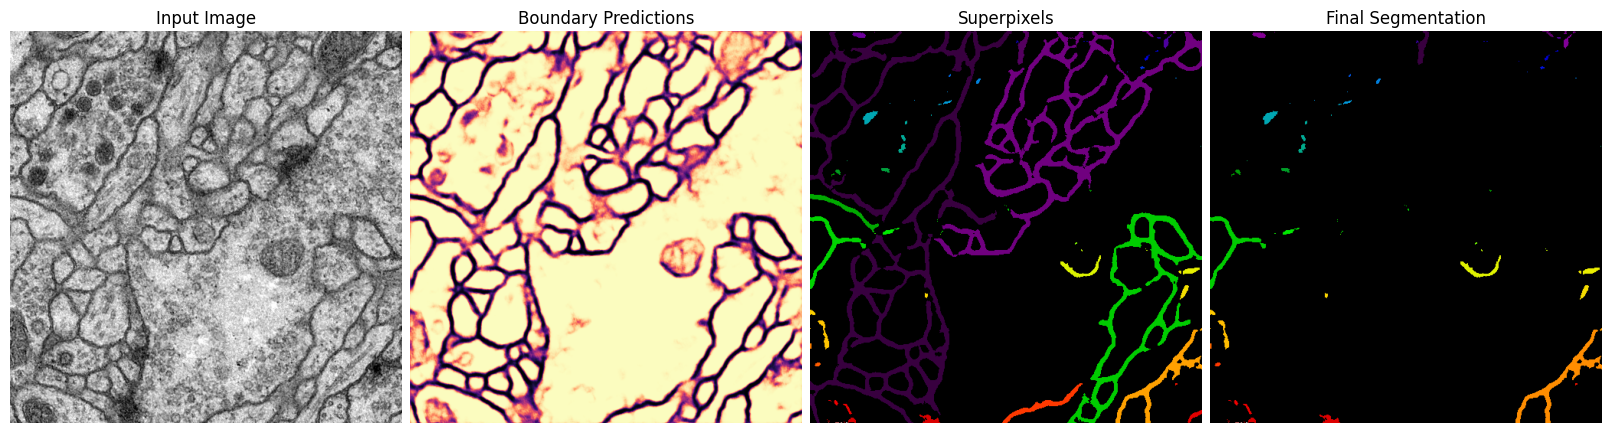

In [ ]:
#
# ISBI Challenge Inference and Benchmarking Script
#
# =================================================================================
# This script is for running inference and benchmarking with a pre-trained
# SteerableUNet model. It does NOT perform any training.
#
# NOTE ON DEPENDENCIES:
# Required libraries (install with pip).
# > pip install torch torchvision numpy scikit-image Pillow matplotlib scikit-learn
# =================================================================================
#
# The pipeline consists of three main stages:
# 1. Boundary Prediction: The pre-trained SFCNN predicts cell boundaries.
# 2. Superpixel Generation: A watershed algorithm creates an oversegmentation.
# 3. Graph-based Segmentation: A Region Adjacency Graph (RAG) is built and
#    regions are merged using a simple threshold cut, all via scikit-image.
#

import os
# FIX for torch._dynamo circular import error in some environments.
# This environment variable MUST be set BEFORE importing torch.
os.environ['TORCH_COMPILE_DISABLE'] = '1'

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.checkpoint import checkpoint
from torchvision.transforms import Compose, ToTensor, Normalize
from PIL import Image

import numpy as np
from scipy.ndimage import distance_transform_edt
from skimage.segmentation import watershed
from skimage.measure import label
from skimage import graph as sk_graph

import math
import matplotlib.pyplot as plt

#
# Model Definition (Required to load the pre-trained weights)
#

def generate_circular_harmonics_basis(kernel_size, radial_params, max_angular_freqs):
    """
    Generates a basis of complex-valued circular harmonic filters.
    """
    filters = []
    angular_freqs_k = []

    x = torch.linspace(-kernel_size // 2, kernel_size // 2, kernel_size)
    grid_x, grid_y = torch.meshgrid(x, x, indexing='ij')
    r = torch.sqrt(grid_x**2 + grid_y**2)
    phi = torch.atan2(grid_y, grid_x)

    for i, (mean, std) in enumerate(radial_params):
        radial_profile = torch.exp(-(r - mean)**2 / (2 * std**2))
        for k in range(max_angular_freqs[i] + 1):
            angular_part = torch.exp(1j * k * phi)
            filt = radial_profile * angular_part
            norm = torch.sqrt(torch.sum(torch.real(filt)**2 + torch.imag(filt)**2))
            if norm > 1e-6:
                filt = filt / norm
            filters.append(filt)
            angular_freqs_k.append(k)

    return torch.stack(filters).cfloat(), torch.tensor(angular_freqs_k, dtype=torch.float32)

class SteerableCNNLayer(nn.Module):
    """
    A steerable convolution layer that can act as the input layer or a group convolution layer.
    """
    def __init__(self, in_channels, out_channels, kernel_size, num_orientations,
                 radial_params, max_angular_freqs, is_input_layer=False):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_orientations = num_orientations
        self.is_input_layer = is_input_layer

        basis, k_values = generate_circular_harmonics_basis(kernel_size, radial_params, max_angular_freqs)
        self.num_basis_filters = basis.shape[0]
        self.register_buffer('basis', basis)
        self.register_buffer('k_values', k_values)

        weight_shape = (out_channels, in_channels, self.num_orientations, self.num_basis_filters) if not is_input_layer else (out_channels, in_channels, self.num_basis_filters)
        stdv = 1. / math.sqrt(in_channels * self.num_basis_filters)
        self.weights = nn.Parameter(torch.randn(*weight_shape, dtype=torch.cfloat) * stdv)

        orientations = torch.linspace(0, 2 * np.pi, self.num_orientations + 1)[:-1]
        phase_factors = torch.exp(-1j * self.k_values[None, :] * orientations[:, None])
        self.register_buffer('phase_factors', phase_factors.cfloat())

    def forward(self, x):
        if not torch.is_complex(x):
             x = x.cfloat()

        if self.is_input_layer:
            x = x.unsqueeze(2)

        N, C_in, A_in, H, W = x.shape
        x_reshaped = x.reshape(N * C_in * A_in, 1, H, W)

        atomic_responses = F.conv2d(x_reshaped, self.basis.unsqueeze(1), padding='same')
        atomic_responses = atomic_responses.view(N, C_in, A_in, self.num_basis_filters, H, W)

        output = []
        for theta_idx in range(self.num_orientations):
            if self.is_input_layer:
                atomic_squeezed = atomic_responses.squeeze(2)
                phase_for_theta = self.phase_factors[theta_idx, :]
                coeffs = self.weights * phase_for_theta[None, None, :]
                y_theta = torch.einsum('oib,nibxy->noxy', coeffs, atomic_squeezed)
            else:
                w_rolled = torch.roll(self.weights, shifts=-theta_idx, dims=2)
                phase_for_phi = self.phase_factors[:A_in, :]
                coeffs = w_rolled * phase_for_phi[None, None, :, :]
                y_theta = torch.einsum('oipb,nipbxy->noxy', coeffs, atomic_responses)

            output.append(y_theta)

        y = torch.stack(output, dim=2)
        return torch.real(y)

class SteerableUNet(nn.Module):
    """A U-Net using SteerableCNNLayers, adjusted for BCEWithLogitsLoss."""
    def __init__(self, n_channels_in, n_classes, num_orientations=8, kernel_size=5):
        super().__init__()
        self.num_orientations = num_orientations
        radial_params = [(0.0, 1.0), (kernel_size / 4, 1.0)]
        max_angular_freqs = [4, 4]

        c1, c2, c3 = 8, 16, 32

        self.in_layer = SteerableCNNLayer(n_channels_in, c1, kernel_size, self.num_orientations, radial_params, max_angular_freqs, is_input_layer=True)
        self.enc1 = SteerableCNNLayer(c1, c2, kernel_size, self.num_orientations, radial_params, max_angular_freqs)
        self.pool = nn.MaxPool3d(kernel_size=(1, 2, 2))
        self.bottle = SteerableCNNLayer(c2, c3, kernel_size, self.num_orientations, radial_params, max_angular_freqs)
        self.up = nn.Upsample(scale_factor=(1, 2, 2), mode='trilinear', align_corners=False)
        self.dec1 = SteerableCNNLayer(c3 + c2, c2, kernel_size, self.num_orientations, radial_params, max_angular_freqs)
        self.dec2 = SteerableCNNLayer(c2 + c1, c1, kernel_size, self.num_orientations, radial_params, max_angular_freqs)
        self.out_conv = nn.Conv2d(c1, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = F.relu(self.in_layer(x))
        x2 = F.relu(self.enc1(self.pool(x1)))
        b = F.relu(self.bottle(self.pool(x2)))
        d1 = F.relu(self.dec1(torch.cat([self.up(b), x2], dim=1)))
        d2 = F.relu(self.dec2(torch.cat([self.up(d1), x1], dim=1)))
        out_pooled = torch.max(d2, dim=2)[0]
        return self.out_conv(out_pooled)

#
# Data Loading and Inference Functions
#

class TiffStackDataset(Dataset):
    """
    Custom PyTorch Dataset for loading multi-page TIFF stacks.
    """
    def __init__(self, data_file, labels_file, transform=None):
        self.data_file = data_file
        self.labels_file = labels_file
        self.transform = transform

        self.data_stack = Image.open(data_file)
        self.labels_stack = Image.open(labels_file)

        self.num_frames = self.data_stack.n_frames

        if self.num_frames != self.labels_stack.n_frames:
            raise ValueError("Data and labels TIFF stacks must have the same number of frames.")

    def __len__(self):
        return self.num_frames

    def __getitem__(self, idx):
        self.data_stack.seek(idx)
        self.labels_stack.seek(idx)

        image = self.data_stack.copy().convert("L")
        label = self.labels_stack.copy().convert("L")

        if self.transform:
            image = self.transform(image)

        label_tensor = (ToTensor()(label) > 0.5).to(torch.float32)
        return image, label_tensor

#
# Manual Metric Functions (to replace torchmetrics)
#
def manual_dice_score(preds, targets, epsilon=1e-6):
    """Calculates Dice score manually."""
    preds_flat = preds.contiguous().view(-1)
    targets_flat = targets.contiguous().view(-1)
    intersection = (preds_flat * targets_flat).sum()
    dice_score = (2. * intersection + epsilon) / (preds_flat.sum() + targets_flat.sum() + epsilon)
    return dice_score

def manual_jaccard_index(preds, targets, epsilon=1e-6):
    """Calculates Jaccard Index (IoU) manually."""
    preds_flat = preds.contiguous().view(-1)
    targets_flat = targets.contiguous().view(-1)
    intersection = (preds_flat * targets_flat).sum()
    total = (preds_flat + targets_flat).sum()
    union = total - intersection
    jaccard = (intersection + epsilon) / (union + epsilon)
    return jaccard

def get_superpixels(boundary_predictions, threshold=0.5):
    foreground = 1 - boundary_predictions
    binary_mask = foreground > threshold
    distance_transform = distance_transform_edt(binary_mask)
    seeds = label(distance_transform > 0.1 * distance_transform.max())
    superpixels = watershed(-distance_transform, seeds, mask=binary_mask)
    return superpixels

def get_graph_segmentation(boundary_predictions, superpixels):
    g = sk_graph.rag_boundary(superpixels, boundary_predictions)
    labels = sk_graph.cut_threshold(superpixels, g, 0.5)
    return labels

def run_inference_and_display(model, dataset, image_idx, device):
    """Runs the full inference pipeline on a single image and displays results."""
    model.eval()

    image_tensor, _ = dataset[image_idx]
    input_tensor = image_tensor.unsqueeze(0).to(device)

    image_to_display = image_tensor.squeeze().cpu().numpy() * 0.5 + 0.5

    with torch.no_grad():
        boundary_logits = model(input_tensor)
        boundary_preds = torch.sigmoid(boundary_logits).squeeze().cpu().numpy()

    superpixels = get_superpixels(boundary_preds)
    final_segmentation = get_graph_segmentation(boundary_preds, superpixels)

    fig, axes = plt.subplots(1, 4, figsize=(16, 5), constrained_layout=True)
    ax = axes.ravel()
    ax[0].imshow(image_to_display, cmap='gray'); ax[0].set_title('Input Image')
    ax[1].imshow(boundary_preds, cmap='magma'); ax[1].set_title('Boundary Predictions')
    ax[2].imshow(superpixels, cmap='nipy_spectral'); ax[2].set_title('Superpixels')
    ax[3].imshow(final_segmentation, cmap='nipy_spectral'); ax[3].set_title('Final Segmentation')

    for a in ax: a.set_axis_off()
    plt.show()

def run_inference_benchmark(model, test_dataset, device):
    """
    Runs inference on the entire test set and calculates Dice and Jaccard metrics.
    """
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    total_dice = 0.0
    total_jaccard = 0.0

    print("\nStarting inference benchmark on the test set...")
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            preds = torch.sigmoid(outputs)

            # Use manual metric functions
            total_dice += manual_dice_score(preds, labels)
            total_jaccard += manual_jaccard_index(preds, labels)

    avg_dice = total_dice / len(test_loader)
    avg_jaccard = total_jaccard / len(test_loader)

    print("\n--- Inference Benchmark Results ---")
    print(f"Average Dice Score:        {avg_dice:.4f}")
    print(f"Average Jaccard Index (IoU): {avg_jaccard:.4f}")
    print("---------------------------------")


if __name__ == '__main__':
    # ==============================================================================
    # TODO: USER ACTION REQUIRED
    # Update these paths to point to your test data and your trained model file.
    # ==============================================================================
    model_path = './best_steerable_model.pth'
    test_data_file = './isbi_dataset/test_volume/test-volume.tif'
    test_labels_file = './isbi_dataset/test_labels/test-labels.tif'
    # ==============================================================================

    if not all(os.path.exists(p) for p in [model_path, test_data_file, test_labels_file]):
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("!!!               FILE(S) NOT FOUND                       !!!")
        print("!!! Please update the file path variables to point to your!!!")
        print("!!! test dataset and your trained '.pth' model file.      !!!")
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        # Initialize the model architecture. The parameters (e.g., num_orientations)
        # MUST match the architecture of the model that was saved.
        model = SteerableUNet(n_channels_in=1, n_classes=1, num_orientations=8, kernel_size=5).to(device)

        # Load the pre-trained weights
        print(f"Loading pre-trained model from: {model_path}")
        model.load_state_dict(torch.load(model_path, map_location=device))

        # Create the test dataset
        # Note: We use a simple ToTensor and Normalize transform for inference, no random augmentation.
        test_transform = Compose([ToTensor(), Normalize(mean=[0.5], std=[0.5])])
        test_dataset = TiffStackDataset(test_data_file, test_labels_file, transform=test_transform)

        # Run the quantitative benchmark on the full test set
        if len(test_dataset) > 0:
            run_inference_benchmark(model, test_dataset, device)
        else:
            print("Test dataset is empty. Skipping benchmark.")

        # Run and display qualitative results on the first test image
        if len(test_dataset) > 0:
            print("\nDisplaying qualitative results on a sample test image...")
            run_inference_and_display(model, test_dataset, 0, device)


ISBI-2012 EM Benchmark Emulation

In [ ]:
#
# ISBI Challenge Official Benchmark Script (Python Recreation)
#
# =================================================================================
# This script is for BENCHMARKING ONLY. It loads a pre-trained model and
# evaluates it against a test set using the official ISBI challenge metrics.
# It does NOT perform any training.
#
# NOTE ON DEPENDENCIES:
# This version has been simplified to use 'scikit-image' for the final
# segmentation step, removing the need for 'nifty' which can be difficult
# to install.
#
# Required libraries (install with pip):
# > pip install torch torchvision numpy scikit-image Pillow matplotlib scikit-learn
# =================================================================================
#

import os
# FIX for torch._dynamo circular import error in some environments.
# This environment variable MUST be set BEFORE importing torch.
os.environ['TORCH_COMPILE_DISABLE'] = '1'

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize
from PIL import Image

import numpy as np
from scipy.ndimage import distance_transform_edt
from skimage.segmentation import watershed, relabel_sequential
from skimage.measure import label
from skimage.metrics import adapted_rand_error, variation_of_information
from skimage import graph as sk_graph

import math
import matplotlib.pyplot as plt

#
# ==============================================================================
# STEP 1: DEFINE THE MODEL ARCHITECTURE
# This is required so PyTorch can create a model object with the correct
# structure before we can load your saved weights into it.
# ==============================================================================
#

def generate_circular_harmonics_basis(kernel_size, radial_params, max_angular_freqs):
    filters = []
    angular_freqs_k = []
    x = torch.linspace(-kernel_size // 2, kernel_size // 2, kernel_size)
    grid_x, grid_y = torch.meshgrid(x, x, indexing='ij')
    r = torch.sqrt(grid_x**2 + grid_y**2)
    phi = torch.atan2(grid_y, grid_x)
    for i, (mean, std) in enumerate(radial_params):
        radial_profile = torch.exp(-(r - mean)**2 / (2 * std**2))
        for k in range(max_angular_freqs[i] + 1):
            angular_part = torch.exp(1j * k * phi)
            filt = radial_profile * angular_part
            norm = torch.sqrt(torch.sum(torch.real(filt)**2 + torch.imag(filt)**2))
            if norm > 1e-6: filt = filt / norm
            filters.append(filt)
            angular_freqs_k.append(k)
    return torch.stack(filters).cfloat(), torch.tensor(angular_freqs_k, dtype=torch.float32)

class SteerableCNNLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, num_orientations,
                 radial_params, max_angular_freqs, is_input_layer=False):
        super().__init__()
        self.in_channels, self.out_channels, self.num_orientations, self.is_input_layer = in_channels, out_channels, num_orientations, is_input_layer
        basis, k_values = generate_circular_harmonics_basis(kernel_size, radial_params, max_angular_freqs)
        self.num_basis_filters = basis.shape[0]
        self.register_buffer('basis', basis)
        self.register_buffer('k_values', k_values)
        weight_shape = (out_channels, in_channels, self.num_orientations, self.num_basis_filters) if not is_input_layer else (out_channels, in_channels, self.num_basis_filters)
        stdv = 1. / math.sqrt(in_channels * self.num_basis_filters)
        self.weights = nn.Parameter(torch.randn(*weight_shape, dtype=torch.cfloat) * stdv)
        orientations = torch.linspace(0, 2 * np.pi, self.num_orientations + 1)[:-1]
        phase_factors = torch.exp(-1j * self.k_values[None, :] * orientations[:, None])
        self.register_buffer('phase_factors', phase_factors.cfloat())

    def forward(self, x):
        if not torch.is_complex(x): x = x.cfloat()
        if self.is_input_layer: x = x.unsqueeze(2)
        N, C_in, A_in, H, W = x.shape
        x_reshaped = x.reshape(N * C_in * A_in, 1, H, W)
        atomic_responses = F.conv2d(x_reshaped, self.basis.unsqueeze(1), padding='same')
        atomic_responses = atomic_responses.view(N, C_in, A_in, self.num_basis_filters, H, W)
        output = []
        for theta_idx in range(self.num_orientations):
            if self.is_input_layer:
                atomic_squeezed = atomic_responses.squeeze(2)
                phase_for_theta = self.phase_factors[theta_idx, :]
                coeffs = self.weights * phase_for_theta[None, None, :]
                y_theta = torch.einsum('oib,nibxy->noxy', coeffs, atomic_squeezed)
            else:
                w_rolled = torch.roll(self.weights, shifts=-theta_idx, dims=2)
                phase_for_phi = self.phase_factors[:A_in, :]
                coeffs = w_rolled * phase_for_phi[None, None, :, :]
                y_theta = torch.einsum('oipb,nipbxy->noxy', coeffs, atomic_responses)
            output.append(y_theta)
        return torch.real(torch.stack(output, dim=2))

class SteerableUNet(nn.Module):
    def __init__(self, n_channels_in, n_classes, num_orientations=8, kernel_size=5):
        super().__init__()
        self.num_orientations = num_orientations
        radial_params = [(0.0, 1.0), (kernel_size / 4, 1.0)]
        max_angular_freqs = [4, 4]
        c1, c2, c3 = 8, 16, 32
        self.in_layer = SteerableCNNLayer(n_channels_in, c1, kernel_size, self.num_orientations, radial_params, max_angular_freqs, is_input_layer=True)
        self.enc1 = SteerableCNNLayer(c1, c2, kernel_size, self.num_orientations, radial_params, max_angular_freqs)
        self.pool = nn.MaxPool3d(kernel_size=(1, 2, 2))
        self.bottle = SteerableCNNLayer(c2, c3, kernel_size, self.num_orientations, radial_params, max_angular_freqs)
        self.up = nn.Upsample(scale_factor=(1, 2, 2), mode='trilinear', align_corners=False)
        self.dec1 = SteerableCNNLayer(c3 + c2, c2, kernel_size, self.num_orientations, radial_params, max_angular_freqs)
        self.dec2 = SteerableCNNLayer(c2 + c1, c1, kernel_size, self.num_orientations, radial_params, max_angular_freqs)
        self.out_conv = nn.Conv2d(c1, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = F.relu(self.in_layer(x))
        x2 = F.relu(self.enc1(self.pool(x1)))
        b = F.relu(self.bottle(self.pool(x2)))
        d1 = F.relu(self.dec1(torch.cat([self.up(b), x2], dim=1)))
        d2 = F.relu(self.dec2(torch.cat([self.up(d1), x1], dim=1)))
        out_pooled = torch.max(d2, dim=2)[0]
        return self.out_conv(out_pooled)

#
# ==============================================================================
# STEP 2: DEFINE DATA LOADING AND PIPELINE FUNCTIONS
# ==============================================================================
#
class TiffStackDataset(Dataset):
    def __init__(self, data_file, labels_file, transform=None, is_ground_truth=False):
        self.data_stack = Image.open(data_file)
        self.labels_stack = Image.open(labels_file)
        self.transform = transform
        self.is_ground_truth = is_ground_truth
        self.num_frames = self.data_stack.n_frames
        if self.num_frames != self.labels_stack.n_frames: raise ValueError("Data and labels have different number of frames.")

    def __len__(self):
        return self.num_frames

    def __getitem__(self, idx):
        self.data_stack.seek(idx)
        self.labels_stack.seek(idx)
        image = self.data_stack.copy().convert("L")
        label_pil = self.labels_stack.copy().convert("L")
        if self.transform: image = self.transform(image)
        label = np.array(label_pil) if self.is_ground_truth else (ToTensor()(label_pil) > 0.5).to(torch.float32)
        return image, label

def get_superpixels(boundary_predictions, threshold=0.5):
    foreground = 1 - boundary_predictions
    binary_mask = foreground > threshold
    distance_transform = distance_transform_edt(binary_mask)
    seeds = label(distance_transform > 0.1 * distance_transform.max())
    return watershed(-distance_transform, seeds, mask=binary_mask)

def get_agglomerative_segmentation(boundary_predictions, superpixels):
    """
    Performs agglomerative segmentation using scikit-image's RAG and
    a version-agnostic threshold cut.
    """
    rag = sk_graph.rag_boundary(superpixels, boundary_predictions)

    # This is a stable, reliable method for merging superpixels that works
    # across different scikit-image versions.
    merged_labels = sk_graph.cut_threshold(superpixels, rag, thresh=0.5)

    return merged_labels

#
# ==============================================================================
# STEP 3: RUN THE BENCHMARK
# ==============================================================================
#
def run_official_benchmark(model, test_dataset, device):
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    total_rand_error, total_vi_split, total_vi_merge = 0.0, 0.0, 0.0

    print("\nStarting official benchmark on the test set...")
    with torch.no_grad():
        for i, (images, gt_labels) in enumerate(test_loader):
            images, gt_labels_np = images.to(device), gt_labels.squeeze().numpy().astype(np.int32)

            # Run the full pipeline to get proposed segmentation
            outputs = model(images)
            boundary_preds = torch.sigmoid(outputs).squeeze().cpu().numpy()
            superpixels = get_superpixels(boundary_preds)
            proposed_labels = get_agglomerative_segmentation(boundary_preds, superpixels)
            proposed_labels, _, _ = relabel_sequential(proposed_labels)

            # Calculate metrics
            arand, _, _ = adapted_rand_error(gt_labels_np, proposed_labels)
            vi_s, vi_m = variation_of_information(gt_labels_np, proposed_labels)
            total_rand_error += arand
            total_vi_split += vi_s
            total_vi_merge += vi_m

            print(f"  Processed image {i+1}/{len(test_loader)}...")

    num_samples = len(test_loader)
    avg_rand_error = total_rand_error / num_samples
    avg_vi_split = total_vi_split / num_samples
    avg_vi_merge = total_vi_merge / num_samples

    # The ISBI challenge score is often reported as 1 - error
    v_rand_score = 1.0 - avg_rand_error

    print("\n--- Official ISBI Benchmark Results ---")
    print("\n--- V_rand (Foreground-Restricted Rand) ---")
    print(f"Rand Error: {avg_rand_error:.4f}")
    print(f"V_rand Score: {v_rand_score:.4f} (Higher is better)")

    print("\n--- V_info (Variation of Information) ---")
    print(f"V_info Split component: {avg_vi_split:.4f} (Lower is better)")
    print(f"V_info Merge component: {avg_vi_merge:.4f} (Lower is better)")
    print("-----------------------------------------")


if __name__ == '__main__':
    # ==============================================================================
    # TODO: USER ACTION REQUIRED
    # Update these paths to point to your test data and your trained model file.
    # ==============================================================================
    model_path = './best_steerable_model.pth'
    test_data_file = './isbi_dataset/test_volume/test-volume.tif'
    test_labels_file = './isbi_dataset/test_labels/test-labels.tif'
    # ==============================================================================

    if not all(os.path.exists(p) for p in [model_path, test_data_file, test_labels_file]):
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("!!!               FILE(S) NOT FOUND                       !!!")
        print("!!! Please update the file path variables to point to your!!!")
        print("!!! test dataset and your trained '.pth' model file.      !!!")
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        # Initialize the model architecture. The parameters (e.g., num_orientations)
        # MUST match the architecture of the model that was saved.
        model = SteerableUNet(n_channels_in=1, n_classes=1, num_orientations=8, kernel_size=5).to(device)

        # Load the pre-trained weights
        print(f"Loading pre-trained model from: {model_path}")
        model.load_state_dict(torch.load(model_path, map_location=device))

        # Create the test dataset
        test_transform = Compose([ToTensor(), Normalize(mean=[0.5], std=[0.5])])
        test_dataset = TiffStackDataset(test_data_file, test_labels_file, transform=test_transform, is_ground_truth=True)

        # Run the quantitative benchmark on the full test set
        if len(test_dataset) > 0:
            run_official_benchmark(model, test_dataset, device)
        else:
            print("Test dataset is empty. Skipping benchmark.")


Using device: cuda
Loading pre-trained model from: ./best_steerable_model.pth

Starting official benchmark on the test set...
  Processed image 1/30...
  Processed image 2/30...
  Processed image 3/30...
  Processed image 4/30...
  Processed image 5/30...
  Processed image 6/30...
  Processed image 7/30...
  Processed image 8/30...
  Processed image 9/30...
  Processed image 10/30...
  Processed image 11/30...
  Processed image 12/30...
  Processed image 13/30...
  Processed image 14/30...
  Processed image 15/30...
  Processed image 16/30...
  Processed image 17/30...
  Processed image 18/30...
  Processed image 19/30...
  Processed image 20/30...
  Processed image 21/30...
  Processed image 22/30...
  Processed image 23/30...
  Processed image 24/30...
  Processed image 25/30...
  Processed image 26/30...
  Processed image 27/30...
  Processed image 28/30...
  Processed image 29/30...
  Processed image 30/30...

--- Official ISBI Benchmark Results ---

--- V_rand (Foreground-Restrict